Data coming from FTIR experiment were cleaned and features were engineerd. Data coming from measurements of samples in paraffine and deparaffinized were treated separately.

#### Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_PAR = pd.read_csv('data/ratios_PAR.csv', index_col='Unnamed: 0')
df_DEP = pd.read_csv('data/ratios_DEP.csv', index_col='Unnamed: 0')

In [3]:
df_PAR.columns

Index(['Patient', 'Sample', 'Category', 'Unsaturated/saturated lipid ratio',
       'Lipid saturation', 'Carbonyl/lipid ratio', 'Lipid/protein ratio',
       'Alpha helix/beta sheets', 'Percentage of beta forms',
       'Biomass I/Biomass II', 'Amide III/Amide I', '1080/1240', '1450/1390',
       '1080/Amide I', '10240/Amide I', '(1450+1390)/Lipids', '1450/Lipids',
       '1390/Lipids', 'Amide B/Amide I', 'Amide III/Amide B', 'CH3/1450',
       '2850/1450'],
      dtype='object')

### MODELS

The purpose of this study was to check if the samples after embedding in paraffine and samples after deparaffinizaion still contain enough molecular information to allow for distinguishing between different types of diseased samples.

For the purpose od samples classification random forest (RF) model was used, as also allows for easy understanding of features importance.

### 1. Samples in PARAFFINE

#### (1a) Model including all types of samples (HGSC, MUC, ENDOM, CONTROL)

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [5]:
def prepare_sets_standard(df, random_state=None):
    """
    function which splits to train and test sets in a typical way
    as opposed to what will be introduced in chapter (1c).
    the function accepts typical train_test_split parameters
    """
    y = df.Category
    X = df.drop(['Patient', 'Sample', 'Category'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

In [6]:
def get_best_params(sets):
    """
    function which will find the best hyperparameters for given train and test sets
    it takes a tuple containing following dataests: X_train, X_test, y_train, y_test
    """
    X_train, X_test, y_train, y_test = sets
    #defining parameters for GridSearchCV
    random_grid = {'max_features': [4, 5, 6],
               'max_depth': [5, 10, None],
               'min_samples_split': [2, 5],
               'min_samples_leaf': [1,2],
               'bootstrap': [True, False]}
    #fitting the models
    rf_model = RandomForestClassifier(n_estimators = 100)
    rf_grid = GridSearchCV(estimator=rf_model, param_grid=random_grid, cv=3)
    rf_grid.fit(X_train, y_train)
    
    return rf_grid.best_params_

In [7]:
from sklearn.metrics import accuracy_score, f1_score

def to_features_and_scores(sets, **kwargs):
    """
    function which returns features importance and evaluates the performance of the model.
    it takes a tuple containing following datasets: X_train, X_test, y_train, y_test.
    it can take an additional argument as dictionary with hyperparameters values.
    """
    X_train, X_test, y_train, y_test = sets
    
    rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, **kwargs)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    #calculaet metrics and get features
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, labels = pd.DataFrame(y_train).Category.unique(), average=None)
    features = pd.DataFrame(rf_model.feature_importances_, index=X_train.columns, columns = ['Importance']).sort_values(by=['Importance'], ascending=False)
    
    return accuracy, f1, features

In [8]:
import statistics

def average_importances_and_scores(df, n, split_function, **kwargs):
    """
    for given dataset and number of repeats (optionally dictionary with best parameters for RF model)
    it will return features importance and accuracy and f1 scores
    averaged after n runs with different train-test splits
    """
    #define variables to store values from individual runs
    features_rank = pd.DataFrame(0, index=df.drop(['Patient', 'Sample', 'Category'], axis=1).columns, columns=['Importance'])
    accuracy_scores = []
    f1_scores = pd.DataFrame(columns = df.Category.unique())
    
    #fill the variables with data from n independant experiments
    for i in range(n):
        #calculate scores and features for model trained with dataset split with different random_states
        a, f1, f = to_features_and_scores(split_function(df), **kwargs)
        accuracy_scores.append(a)
        f1_scores.loc[len(f1_scores)] = f1
        features_rank = features_rank + f
    
    #calculate averages
    features_rank['Importance'] = features_rank['Importance']/n
    features_rank.reset_index(inplace=True)
    features_rank = features_rank.rename(columns = {'index':'Feature'})
    sorted_features = features_rank.sort_values(by=['Importance'], ascending=False)
    
    accs = sum(accuracy_scores) / len(accuracy_scores)
    u_accs = statistics.stdev(accuracy_scores)
    
    f1s = f1_scores.rename(columns=lambda s: s.replace("_par","_f1_avg").replace("_dep","_f1_avg")).mean().to_dict()
    u_f1s = f1_scores.rename(columns=lambda s: s.replace("_par","_f1_std").replace("_dep","_f1_std")).std().to_dict()
    
    #put all scores in one dictionary
    scores_dict = {'accs':accs, 'u_accs':u_accs, **f1s, **u_f1s}
    
    return scores_dict, sorted_features

Let's start by optimizing hyperparameters of Random Forest model

In [9]:
best_parameters = get_best_params(prepare_sets_standard(df_PAR, random_state=0)) 

Using those optimized parameters we can fit the model multiple times with different train-test splits in order to get averaged values and standard deviations

In [10]:
scores, features = average_importances_and_scores(df_PAR, 100, prepare_sets_standard, **best_parameters)

We can plot the features importance

In [11]:
def plot_features(features, name):
    sns.barplot(y = features['Feature'], x = features['Importance'], palette="crest")
    plt.tight_layout()
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title(name)
    plt.savefig(name)

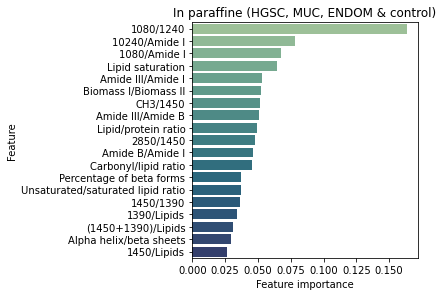

In [12]:
plot_features(features, 'In paraffine (HGSC, MUC, ENDOM & control)')

The 1080 cm-1 and 1240 cm-1 bands originate from vibrations of phosphate groups. They are present in  nucleic acids, so differences in their levels may be a result of increased replication in cancerous cells.

Let's have a look at the scores evaluating model's performance. 

In [13]:
scores

{'accs': 0.9238608045567814,
 'u_accs': 0.003394725718744279,
 'CONTROL_f1_avg': 0.9259189412725876,
 'ENDOM_f1_avg': 0.9050864353119793,
 'HGSC_f1_avg': 0.8782969391203734,
 'MUC_f1_avg': 0.8544974686710889,
 'CONTROL_f1_std': 0.0251132779837741,
 'ENDOM_f1_std': 0.037301114181862834,
 'HGSC_f1_std': 0.033616986799027596,
 'MUC_f1_std': 0.031576237720503435}

We can see that the accuracy score (accs) is relatively high, however if we take a look at f1 scores we can see quite big differences between the values calculated for different classes (CONTROL, ENDOM, HGSC, MUC). It can be noticed that for CONTROL and ENDOM samples, which scored 0.83 and 0.88 respectively, the model performed significantly worse than for HGSC and MUC samples (0.94 and 0.91).

The reason for those differences in the model's performance may be that CONTROL and ENDOM samples are underreprezented accounting only for 4% and 7% of data respectively.

In [14]:
df_PAR[['Sample', 'Category']].groupby(['Category']).count()/len(df_PAR)*100

,Sample
Category,
CONTROL_par,4.223033
ENDOM_par,6.857423
HGSC_par,57.013172
MUC_par,31.906372


To approach this problem I could do sampling of the dataset, which would allow for building models on balaced datasets. Alternatively using penalized models could be an option. However in this study ~1000 spectra from CONTROL GROUP originate from 2 patients and ~1700 spectra from ENDOM group come from 4 different samples from 1 patient. For this reason I will drop CONTROL and ENDOM samples from this study and continue with HGSC and MUC samples.

In [15]:
df_PAR[['Patient', 'Sample', 'Category','1080/1240']].groupby(['Category', 'Patient', 'Sample']).count()

1080/1240
Category    Patient    Sample           
CONTROL_par 1915091R   N 39          701
            1976219    N 19          248
ENDOM_par   1910239    N 14 ?        332
                       N 15 ?        334
                       N 54 ?        392
                       N 55 ?        483
HGSC_par    1892422M   N 35          425
            1897426B   N 36          645
            1913751F   N 37          221
                       N 38          175
            1925473A   N 41           85
            1948174H   N 80          189
            1955654O   N 79          443
            1966577J   N 34          545
            1968866B   N 33          680
            1969819N   N 32          251
            1984314A   N 43          396
            1991600    N 42          431
            1993244E   N 81          211
            1995662B   N 28          538
            2008533A   N 29          709
            2019055A   N 30          753
            2021352K   N 76          641
            2024284G   Brak          701
            2031324J   N 44 ?        122
                       N 45 ?        240
            2035095/12 N 82          648
            2071876    N 24 ?        583
                       N 25 ?        416
                       N 27 ?       1724
            2073370    N 46 ?        387
                       N 47 ?        158
            2081892    N 23          211
            2082920    N 83          284
MUC_par     1899156B   N 22          725
            1934672F   N 49 ?        729
                       N 50 ?        678
            1958490E   N 26         1462
            1959217    N 48          959
            1976219    N 18          269
            1990869    N 20 ?        450
                       N 21 ?        747
            2056003    N 51 ?        415
                       N 52 ?        483
                       N 74 ?        253

For the purpose of comparing the different approaches later I will keep the scores in a dataset.

In [16]:
scores['dataset'] = 'PAR all'
scores = {k:[v] for k,v in scores.items()}
df_scores = pd.DataFrame.from_dict(scores)

#### (1b) Model including only HGSC and MUC samples

For the reasons mentioned in the previous part only HGSC and MUC samples which were considered in this model.

In [17]:
#leave only two types of cancer (HGSC and MUC)
df_PAR_HM = df_PAR[df_PAR.Category.str.contains('HGSC|MUC')]

Let's find the best hyperparameters for RF model...

In [18]:
best_parameters = get_best_params(prepare_sets_standard(df_PAR_HM, random_state=0)) 

...and get scores and features averaged after fitting the model 100 times

In [19]:
scores, features = average_importances_and_scores(df_PAR_HM, 100, prepare_sets_standard, **best_parameters)

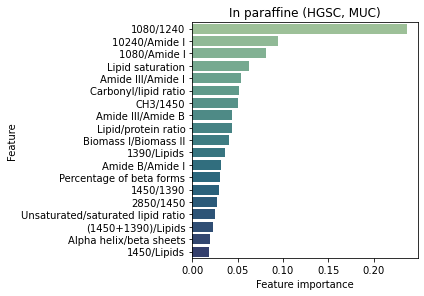

In [20]:
plot_features(features, 'In paraffine (HGSC, MUC)')

We can see that like in the previous case, where all types of samples were taken into accout, here also  1080 cm-1 and 1240 cm-1 bands play the most important role in distinguishing between different types of tissues.

The scores of the model are presented below

In [21]:
scores

{'accs': 0.9438851080864701,
 'u_accs': 0.003109908175889133,
 'HGSC_f1_avg': 0.9448714053433649,
 'MUC_f1_avg': 0.9311680350700914,
 'HGSC_f1_std': 0.018259758408268868,
 'MUC_f1_std': 0.018274891398553598}

We can see that overall the model scored better for HGSC and MUC then it scored before (for four types of tissues). The reason for that is that now it's a binary problem, which is easier to classify. Let's keep the scores for later.

In [22]:
scores['dataset'] = 'PAR HM'
df_scores = df_scores.append(scores, ignore_index=True)

We can't however be sure that the model is learning to recognize the disease and not the patient (spectra measured for the same patient). For this reason I decided to split samples into training and test set based on patient code this way that all samples coming from the same patient end up either in training or test set.

#### (1c) Model including only HGSC and MUC samples (patient-wise train-test split)

Let's define a funstion which allows for patient-wise split of the cases into training and test sets.

In [23]:
def patientwise_split(df):
    """
    Function which splits a given dataset train and test sets
    by putting ALL records REPRESENTING THE SAME PATIENT either to train or test set
    """
    train_size = 0.75
    #Find a list of samples representing HGSC category, sample a specified part to train set
    #and put the rest to test set
    HGSC = df[['Patient']].drop_duplicates().loc[df['Category'].str.contains('HGSC')]
    HGSC_train = HGSC.sample(n=int(train_size*len(HGSC))).Patient.unique()
    HGSC = HGSC.Patient.unique()
    HGSC_test = set(HGSC) - set(HGSC_train)
    
    #Train test split for MUC samples
    MUC = df[['Patient']].drop_duplicates().loc[df['Category'].str.contains('MUC')]
    MUC_train = MUC.sample(n=int(train_size*len(MUC))).Patient.unique()
    MUC = MUC.Patient.unique()
    MUC_test = list(set(MUC) - set(MUC_train))
    
    df_train = df.loc[(df['Category'].str.contains('MUC')) & (df['Patient'].isin(MUC_train)) | (df['Category'].str.contains('HGSC')) & (df['Patient'].isin(HGSC_train))]
    df_test = df.loc[(df['Category'].str.contains('MUC')) & (df['Patient'].isin(MUC_test)) | (df['Category'].str.contains('HGSC')) & (df['Patient'].isin(HGSC_test))]
    X_train = df_train.drop(['Patient', 'Sample', 'Category'], axis=1)
    y_train = df_train.Category
    X_test = df_test.drop(['Patient', 'Sample', 'Category'], axis=1)
    y_test = df_test.Category
    return X_train, X_test, y_train, y_test

Let's find the best hyperparameters for RF model...

In [24]:
best_parameters = get_best_params(patientwise_split(df_PAR_HM)) 

...and get scores and features averaged after fitting the model 100 times

In [25]:
scores, features = average_importances_and_scores(df_PAR_HM, 100, patientwise_split, **best_parameters)

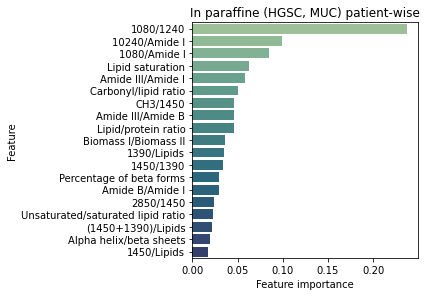

In [26]:
plot_features(features, 'In paraffine (HGSC, MUC) patient-wise')

The scores of the model are presented below

In [27]:
scores

{'accs': 0.7253101519031,
 'u_accs': 0.08071173061821724,
 'HGSC_f1_avg': 0.7980342470239918,
 'MUC_f1_avg': 0.5435550659749113,
 'HGSC_f1_std': 0.06376743188773151,
 'MUC_f1_std': 0.15694964118103805}

The decrease in f1 scores can be partly caused by the fact that especially for MUC samples data originated from few patients. However, it can;t be excluded that the previous models' accuracy was increased by them learning to the patient and not the disease. 

For this reason, for future studies I would recommend using patient-wise split.

On the other hand features which are important in classification process are the same for this (patient-wise split) model as were for the previous two (random split) models. This may suggest that despite using an arguable method for train-test splits the previous models were also learning to recognize the disease (and not the patient), however it can't be proved.

In [28]:
scores['dataset'] = 'PAR HM patient'
df_scores = df_scores.append(scores, ignore_index=True)

### 2. Samples after DEPARAFFINIZATION

Let's repeat all steps for the same samples after deparaffinization.

#### (2a) Model including all types of samples (HGSC, MUC, ENDOM, CONTROL)

Let's find the best hyperparameter for the RF model.


In [29]:
best_parameters = get_best_params(prepare_sets_standard(df_DEP, random_state=0)) 

Having those, we can fit the model 100 times with different train-test splits to improve statistics.

In [30]:
scores, features = average_importances_and_scores(df_DEP, 100, prepare_sets_standard, **best_parameters)

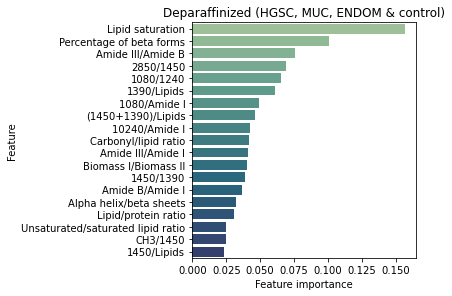

In [31]:
plot_features(features, 'Deparaffinized (HGSC, MUC, ENDOM & control)')

We can see that comparing to the samples embedded in paraffine different features have an importance in separation between different categories of the samples. The importance of lipid saturation suggests that not all lipids were washed out during deparaffinization process and those left still carry the essential information helpful in distinguishing between differentt cancerous tissues. The fact that this feature had no significant importance for the separation of the samples in paraffine may be caused by paraffine masking real content of lipids. Percentage of beta forms carries information about changes in the secondary structure of proteines which is known to change in cancerous tissues.

The model scored as follows

In [32]:
scores

{'accs': 0.9566186440677967,
 'u_accs': 0.004364126279376036,
 'CONTROL_f1_avg': 0.9552457333608811,
 'ENDOM_f1_avg': 0.946414367701966,
 'HGSC_f1_avg': 0.8850311958616898,
 'MUC_f1_avg': 0.8911763656439412,
 'CONTROL_f1_std': 0.020328997168702047,
 'ENDOM_f1_std': 0.02128957629260504,
 'HGSC_f1_std': 0.05211902365486114,
 'MUC_f1_std': 0.05024506083723006}

We can see that deparaffinized samples carry much more information which allows for accurate classification of control and ENDOM samples despite limited number of cases. Alternatively we can't exclude that the model learned how to recognize specific patients.

In [33]:
scores['dataset'] = 'DEP all'
df_scores = df_scores.append(scores, ignore_index=True)

#### (2b) Model including only HGSC and MUC samples 

Like in the case of samples embedded in paraffine as the next step we will consider only HGSC and MUC samples.

In [34]:
#leave only two types of cancer (HGSC and MUC)
df_DEP_HM = df_DEP[df_DEP.Category.str.contains('HGSC|MUC')]

Let's find the best hyperparameter for the RF model....

In [35]:
best_parameters = get_best_params(prepare_sets_standard(df_DEP_HM, random_state=0)) 

... and fit the model 100 times with different train-test splits to improve statistics.

In [36]:
scores, features = average_importances_and_scores(df_DEP_HM, 100, prepare_sets_standard, **best_parameters)

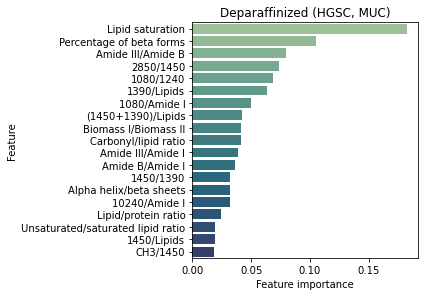

In [37]:
plot_features(features, 'Deparaffinized (HGSC, MUC)')

As we can see the importance of features allowing for distinguishing between HGSC and MUC is similar to this we obtained for distinguishing between HGSC, MUC, ENDOM & control samples. 

In [38]:
scores

{'accs': 0.9621984265734267,
 'u_accs': 0.0039374862741796135,
 'HGSC_f1_avg': 0.9624770423540971,
 'MUC_f1_avg': 0.9501157162068425,
 'HGSC_f1_std': 0.01533011240737281,
 'MUC_f1_std': 0.016120718443761905}

In [39]:
scores

{'accs': 0.9621984265734267,
 'u_accs': 0.0039374862741796135,
 'HGSC_f1_avg': 0.9624770423540971,
 'MUC_f1_avg': 0.9501157162068425,
 'HGSC_f1_std': 0.01533011240737281,
 'MUC_f1_std': 0.016120718443761905}

In [40]:
scores['dataset'] = 'DEP HM'
df_scores = df_scores.append(scores, ignore_index=True)

#### (2c) Model including only HGSC and MUC samples (patient-wise train-test split)

In [41]:
best_parameters = get_best_params(patientwise_split(df_DEP_HM)) 

In [42]:
scores, features = average_importances_and_scores(df_DEP_HM, 100, patientwise_split, **best_parameters)

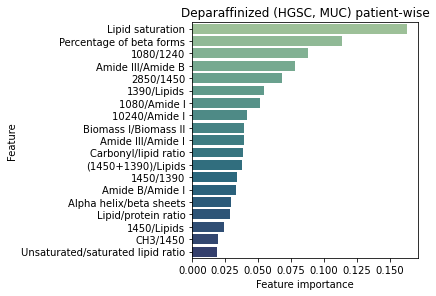

In [43]:
plot_features(features, 'Deparaffinized (HGSC, MUC) patient-wise')

In [44]:
scores

{'accs': 0.6431481513746792,
 'u_accs': 0.16742853565981883,
 'HGSC_f1_avg': 0.7510742236391691,
 'MUC_f1_avg': 0.25973347095542254,
 'HGSC_f1_std': 0.14899299879737998,
 'MUC_f1_std': 0.16285994193869258}

Most important features remained unchanged comparing to the previous models for deparaffinized samples. However, for MUC samples after deparaffinization we can see a radical drop in accuracy of classification.

In [45]:
scores['dataset'] = 'DEP HM patient'
df_scores = df_scores.append(scores, ignore_index=True)

In [46]:
df_scores.to_csv('scores.csv')

### 3. Summary

#### (3a) Features importance

For all models for the samples in paraffine, the most important features were ratios of 1080 cm-1 and 1240 cm-1 bands and their respective ratios with Amide I. Aforementioned bands are vibrations of phosphate groups and they are present in nucleic acids, so differences in their levels may be a result of increased replication in cancerous cells.

For the samples after deparaffinization the most important features for classification were: lipid saturation, which was masked by paraffine before and percentage of beta forms which carries information about changes in the secondary structure of proteines (which is known to change in cancerous tissues).

#### (3b) Scores

In [47]:
#df_scores = pd.read_csv('scores.csv', index_col='Unnamed: 0')

In [48]:
df_scores = df_scores.drop(['accs', 'u_accs','CONTROL_f1_std', 'ENDOM_f1_std',
       'HGSC_f1_std', 'MUC_f1_std'], axis=1)
df_scores = df_scores.rename(columns={'CONTROL_f1_avg':'CONTROL', 'ENDOM_f1_avg':'ENDOM', 'HGSC_f1_avg':'HGSC', 'MUC_f1_avg':'MUC'})

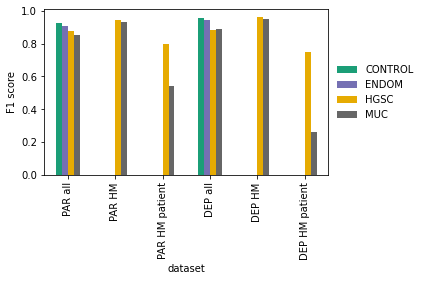

In [55]:
df_scores.plot(x='dataset', kind="bar", cmap='Dark2') 
plt.ylabel('F1 score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.tight_layout()
plt.savefig('scores.jpg')

In the left side of the plot results for samples embedded in paraffine were presented. In the right side we can see data recorded after deparaffinization.

As we can see accuracy of CONTROL and ENDOM samples was the highest. This may be caused by the fact that all datapoints for these categories was originating from two and four patients respectively which could have made the model learn how to recognize the patient and not the disease.

Due to limited number of data for CONTROL and ENDOM and lack of possibility to collect more data the next two models considered only HGCS and MUC samples. The second model used the data randomly split between training and test sets, and the latter the data split in this way that all cases related to a specific patient go only to the training set or only to the test set. 

We can see that the second model (both for PAR and DEP) scores high - better than in the first model because binary classification is an easier problem. We can't exclude that the model is still learning to recognize the patients. 

In the third model we can see a decrease in the accuracy. It may be caused by the fact that now the model can't learn to recognize patients instead of the disease. It is also possible that the accuracy is smaller because the model was trained with smaller variety of data (coming from less patients). It is well visible when we compare scores for HGSC and MUC samples, knowing that despite using ~10 000 datapoints in each group the third model was trained on data coming from 17 patients for HGSC and 4 patients for MUC. Having the amount of data we have we can't say for sure if the model learned to recognize patients or the disease.